## Figure: bibiplots

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

import sys
sys.path.append('../code')
import sparseRRR

In [3]:
def preprocess(data):
    X = data['Firing rate']
    X = X - np.mean(X, axis=0)
    X = X / np.std(X, axis=0)

    Y = data['Locomotion']
    Y = Y - np.mean(Y, axis=0)
    Y = Y / np.std(Y, axis=0)
    
    return X,Y

In [4]:
def adjustlabels(fig, labels, max_iter=1000, eps=0.01, delta=0.1):
    N = len(labels)
    widths = np.zeros(N)
    heights = np.zeros(N)
    centers = np.zeros((N, 2))
    for i,l in enumerate(labels):
        bb = l.get_window_extent(renderer=fig.canvas.get_renderer())
        bb = bb.transformed(plt.gca().transData.inverted())
        widths[i] = bb.width
        heights[i] = bb.height
        centers[i] = (bb.min + bb.max)/2

    for i in range(max_iter):
        stop = True
        for a in range(N):
            for b in range(N):
                if ((a!=b) and
                    (np.abs(centers[a,0]-centers[b,0]) < (widths[a]+widths[b])/2 + delta) and
                    (np.abs(centers[a,1]-centers[b,1]) < (heights[a]+heights[b])/2 +  delta)):
                    
                    d = centers[a] - centers[b]
                    centers[a] += d * eps
                    centers[b] -= d * eps
                    labels[a].set_position(centers[a])
                    labels[b].set_position(centers[b])
                    stop = False
        if stop:
            break

In [6]:
slice = np.linspace(0, 10000, 10000, dtype=int)

In [8]:
data = pickle.load(open('../data/purkinje.pickle', 'rb'))
X,Y = preprocess(data)
print('Shape of X:', X.shape, '\nShape of Y:', Y.shape)
w,v = sparseRRR.relaxed_elastic_rrr(X[slice,:], Y[slice,:], rank=2, alpha=.26, l1_ratio=1)
print('{} neurons selected:'.format(np.sum(w[:,0]!=0)))

Shape of X: (2691968, 105) 
Shape of Y: (2691968, 4)
13 neurons selected:


In [10]:
data.keys()

dict_keys(['Firing rate', 'Locomotion', 'cell_names', 'locomotion_names', 'sampling rate (Hz)'])

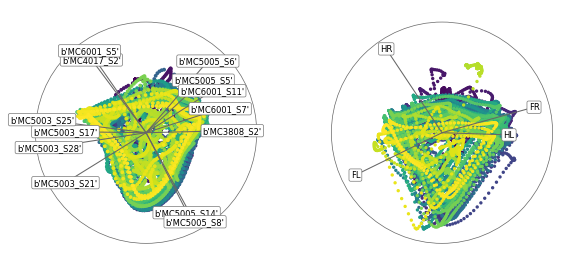

In [18]:
fig = plt.figure(figsize=(7, 5))   

# project data on latent space
Zx = X[slice,:] @ w
Zy = Y[slice,:] @ v
Zx = Zx / np.std(Zx, axis=0)
Zy = Zy / np.std(Zy, axis=0)

colors = range(X[slice,:].shape[0])
xylim=3.9
scaleFactor=3.5
s=2

plt.subplot(1, 2, 1, aspect='equal')
plt.scatter(Zx[:,0], Zx[:,1], s=3, c=colors)

plt.ylim([-xylim, xylim])
plt.xlim([-xylim, xylim])
plt.xticks([])
plt.yticks([])

labels = []
L = np.corrcoef(np.concatenate((Zx[:,:2], X[slice,:]), axis=1), rowvar=False)[2:,:2]
for i in np.where(w[:,0]!=0)[0]:
    plt.plot([0, scaleFactor*L[i,0]], [0, scaleFactor*L[i,1]], linewidth=.75, color=[.4, .4, .4],
        zorder=1)
    t = plt.text(scaleFactor*L[i,0], scaleFactor*L[i,1], data['cell_names'][i], 
        ha='center', va='center', color='k', fontsize=6,
        bbox=dict(facecolor='w', edgecolor='#777777', boxstyle='round', linewidth=.5, pad=.2))
    labels.append(t)
adjustlabels(fig, labels)
circ = plt.Circle((0,0), radius=scaleFactor, color=[.4, .4, .4], fill=False, linewidth=.5)
plt.gca().add_patch(circ)

plt.subplot(1, 2, 2, aspect='equal')
plt.scatter(Zy[:,0], Zy[:,1], s=s, c=colors)

plt.ylim([-xylim, xylim])
plt.xlim([-xylim, xylim])
plt.xticks([])
plt.yticks([])

labels = []
L = np.corrcoef(np.concatenate((Zy[:,:2], Y[slice,:]), axis=1), rowvar=False)[2:,:2]

for i in range(Y.shape[1]):
    plt.plot([0, scaleFactor*L[i,0]], [0, scaleFactor*L[i,1]], linewidth=.75, color=[.4, .4, .4],
            zorder=1)
    t = plt.text(scaleFactor*L[i,0], scaleFactor*L[i,1], data['locomotion_names'][i], 
            ha='center', va='center', color='k', fontsize=6,
            bbox=dict(facecolor='w', edgecolor='#777777', boxstyle='round', linewidth=.5, pad=.2))
    labels.append(t)

adjustlabels(fig, labels)
circ = plt.Circle((0,0), radius=scaleFactor, color=[.4, .4, .4], fill=False, linewidth=.5)
plt.gca().add_patch(circ)
sns.despine(left=True, bottom=True)

plt.savefig('bibiplot.png', dpi=200)
plt.savefig('bibiplot.pdf')